In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from sklearn.metrics import r2_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version_)

In [2]:
# Load and clean the dataset
df = pd.read_csv('GertPollCardMort.csv', sep=';', header=0, index_col=0, parse_dates=True)

In [3]:
# Drop rows with any NaN values
df_cleaned = df.dropna()

In [4]:
# Separate target variable (mortality) and use everything else as features
target = 'death_count'
features = df_cleaned.drop(columns=[target])

In [5]:
# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

In [6]:
# Step 2: Prepare the Data for LSTM
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])  # Predict next day's mortality
    return np.array(X), np.array(y)

n_steps = 30  # 30 days look-back for daily data
X, y = create_sequences(scaled_features, scaled_target, n_steps)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Reshape the data for CNN input (samples, time steps, features)
X_cnn = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Same as for LSTM

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X_cnn[:train_size], X_cnn[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Define the CNN model
model = Sequential()

# Add a Conv1D layer (32 filters, kernel size 3)
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_steps, X_cnn.shape[2])))

# Add a MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a Dense layer with 50 units and ReLU activation
model.add(Dense(50, activation='relu'))

# Add the final output layer for regression (1 unit for mortality prediction)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the CNN model
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
predictions_rescaled = scaler_target.inverse_transform(predictions)

# You can then follow the same steps as before to resample daily predictions to monthly
# And plot actual vs predicted mortality (monthly or daily as required)


Epoch 1/30
85/85 [==============================] - 1s 4ms/step - loss: 0.0363
Epoch 2/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0261
Epoch 3/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 4/30
85/85 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 5/30
85/85 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 6/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 7/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 8/30
85/85 [==============================] - 0s 5ms/step - loss: 0.0210
Epoch 9/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0206
Epoch 10/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 11/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 12/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 13/30
85/85 [==============================

In [8]:
# Step 6: Aggregate Daily Predictions to Monthly Predictions
df_predictions = pd.DataFrame({'date': df_cleaned.index[-len(predictions_rescaled):], 'predicted_mortality': predictions_rescaled.flatten()})
df_predictions.set_index('date', inplace=True)

# Sum daily predictions by month
monthly_predictions = df_predictions.resample('M').sum()

In [9]:
# Inverse transform y_test to get the actual mortality values for the test set
y_test_rescaled = scaler_target.inverse_transform(y_test)

In [10]:
# Get the date range corresponding to the test set
test_dates = df_cleaned.index[-len(y_test_rescaled):]

In [11]:
# Create a DataFrame for y_test with the appropriate date index
df_actual_test = pd.DataFrame({
    'actual_mortality': y_test_rescaled.flatten()
}, index=test_dates)


In [12]:
# Resample the actual test values by month to get monthly sums
df_actual_monthly = df_actual_test.resample('M').sum()


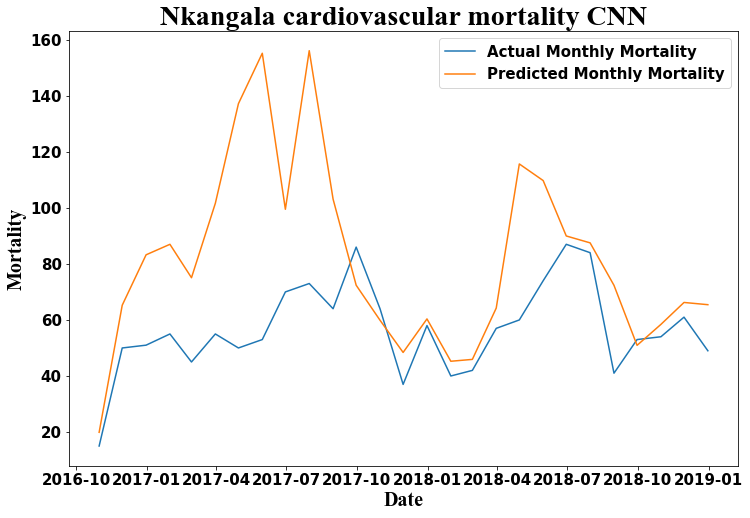

In [13]:
# Plot actual vs predicted monthly mortality
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = '15'
plt.figure(figsize=(12, 8))

# Plot actual vs predicted monthly mortality
plt.plot(df_actual_monthly.index, df_actual_monthly.values, label='Actual Monthly Mortality')
plt.plot(monthly_predictions.index, monthly_predictions['predicted_mortality'].values, label='Predicted Monthly Mortality')

# Customize the x-axis labels
#plt.xticks(rotation=90)

plt.ylabel('Mortality', fontname="Times New Roman", size=20, fontweight="bold")
plt.xlabel('Date', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('Nkangala cardiovascular mortality CNN', fontname="Times New Roman", size=28, fontweight="bold")

# Set legend properties
legend_properties = {'weight': 'bold'}
plt.legend(prop=legend_properties)

plt.show()

In [14]:
mean_absolute_error(df_actual_monthly, monthly_predictions)

26.204220524540656

In [15]:
rmse = sqrt(mean_squared_error(df_actual_monthly, monthly_predictions))
print(rmse)

37.94933192395484


# CNN FOR SHAP

4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

8838/8838 [==============================] - 21s 2ms/step


8838/8838 [==============================] - 18s 2ms/step


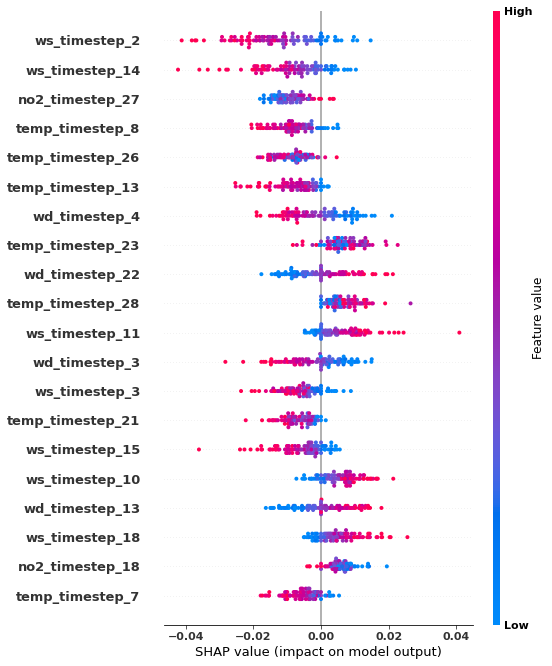

In [16]:
import shap 
# Sample a subset of the test set 
X_test_sample = X_test[:100] # Use a small sample for demonstration 
# Flatten the data for SHAP 
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2])) 
X_test_sample_flattened = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1] * X_test_sample.shape[2]))

# Create a SHAP KernelExplainer 
explainer = shap.KernelExplainer( lambda x: model.predict(x.reshape((x.shape[0], n_steps, X.shape[2]))).reshape(-1), # Ensure the output is 1D 
                                 X_train_flattened[:100] ) 
# Calculate SHAP values for the test sample 
shap_values = explainer.shap_values(X_test_sample_flattened)

# Feature names (flattened time steps and features) 
flattened_feature_names = [f"{feature}_timestep_{i}" for i in range(n_steps) for feature in features.columns] 
# Ensure the length of feature names matches the number of features 
assert len(flattened_feature_names) == X_test_sample_flattened.shape[1], "Feature names length mismatch." 
# Plot summary plot of SHAP values 
shap.summary_plot(shap_values, X_test_sample_flattened, feature_names=flattened_feature_names)

When you use SHAP (SHapley Additive exPlanations) to interpret your LSTM model, you're generating explanations for the predictions by measuring the contribution of each feature.

To visualize the SHAP values in the code you provided, you’re effectively explaining the importance of each feature in predicting death_count. Here's a breakdown of how to interpret the SHAP summary plot:

Feature Importance: The plot shows the impact of each feature on the model’s output. Features are sorted by importance with the most influential ones at the top.

Feature Names: Each feature name includes a timestep and the original feature name (e.g., temperature_timestep_1). This helps you understand which specific times and features are most important.

SHAP Values: Each point represents a SHAP value for a feature at a particular timestep, indicating how much that feature and timestep contributed to increasing or decreasing the predicted death_count.

Color: The color of each point typically represents the value of the feature from low (blue) to high (red). This helps you see how feature values are associated with higher or lower predictions.

# CNN WITH ATTENTION

Epoch 1/30
85/85 [==============================] - 2s 6ms/step - loss: 0.0288
Epoch 2/30
85/85 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 3/30
85/85 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 4/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 5/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 6/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 7/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 8/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 9/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 10/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 11/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 12/30
85/85 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 13/30
85/85 [==============================

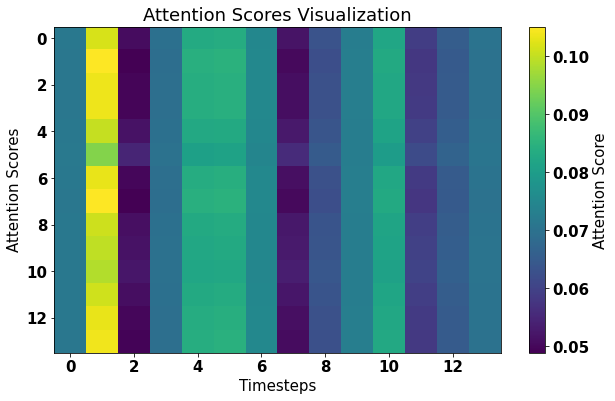

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv1D, Dense, Input, Flatten, Dot, Softmax, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the attention mechanism
def attention_layer(inputs):
    query = Dense(1, use_bias=False)(inputs)  # Query layer
    keys = Dense(1, use_bias=False)(inputs)   # Key layer
    values = Dense(1, use_bias=False)(inputs) # Value layer

    # Compute attention scores
    scores = Dot(axes=[2, 2])([query, keys])  # Shape: (batch_size, n_steps, 1)
    scores = Softmax()(scores)  # Normalize scores
    context_vector = Dot(axes=[1, 1])([scores, values])  # Shape: (batch_size, 1, features)

    return context_vector, scores

# Define the CNN model
def build_cnn_model(n_steps, n_features):
    inputs = Input(shape=(n_steps, n_features))
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    context_vector, attention_scores = attention_layer(x)  # Apply attention mechanism and capture scores
    x = Flatten()(context_vector)
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)  # Output is just the prediction
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model, attention_scores  # Return attention scores for later use

# Load and preprocess data
df = pd.read_csv('GertPollCardMort.csv', sep=';', header=0, index_col=0, parse_dates=True)
df_cleaned = df.dropna()
target = 'death_count'
features = df_cleaned.drop(columns=[target])

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

# Create sequences
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(scaled_features, scaled_target, n_steps)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the CNN model
model, attention_scores = build_cnn_model(n_steps, X.shape[2])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Rescale the predictions
daily_predictions_rescaled = scaler_target.inverse_transform(predictions)

# Evaluate the model to get attention scores
example_input = X_test[:1]  # Use a sample from your test data
attention_model = tf.keras.models.Model(inputs=model.input, outputs=attention_scores)
attention_scores_sample = attention_model.predict(example_input)

# Plot the attention scores
plt.figure(figsize=(10, 6))
plt.imshow(attention_scores_sample[0], aspect='auto', cmap='viridis')
plt.colorbar(label='Attention Score')
plt.xlabel('Timesteps')
plt.ylabel('Attention Scores')
plt.title('Attention Scores Visualization')
plt.show()

The reason your time steps end at 12 instead of the expected 30 likely has to do with the max pooling operation in the CNN. When you use MaxPooling1D with a pool size of 2, it reduces the number of time steps by half with each pooling operation.

Here’s a bit more detail:

Original Time Steps: Your input sequence length is 30.

After Convolution: The length remains the same (30).

After MaxPooling1D(pool_size=2): This reduces the length to 15.